In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay, ModelBasedPrioritizedExperienceReplay
from experiment import Experiment
from dmlac import DMLAC
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy

In [4]:
settings = dict(
    environment = 'Pendulum-v0',
    timesteps = 4000,
    max_replay_buffer_size = 100000,
    batch_size = 256,
    learning_start = 256,
    forward_steps = 1,
    discount_factor = 0.9,
    trace_decay = 0.5,
    
    actor_learning_rate=0.0001,
    model_learning_rate=0.001,
    reward_learning_rate=0.001,
    value_learning_rate=0.001,
    
    actor_l2=None,
    model_l2=None,
    reward_l2=None,
    value_l2=None,
    
    actor_target_approach_rate=0.99,
    value_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    value_net_layers =  [256, 128],
    value_net_activation_fn = tf.nn.elu,
    model_net_embedding = 128,
    model_net_layers = [128],
    model_net_activation_fn = tf.nn.elu,
    reward_net_embedding = 128,
    reward_net_layers =  [128],
    reward_net_activation_fn = tf.nn.elu,
    
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_environment = True,
    render_frequency = 10,
    render_start=3500,
)

settings["experiment_path"] = "experiments/experiment_dmlac_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["model_tf_optimizer"] = tf.train.AdamOptimizer(settings["model_learning_rate"])
settings["reward_tf_optimizer"] = tf.train.AdamOptimizer(settings["reward_learning_rate"])
settings["value_tf_optimizer"] = tf.train.AdamOptimizer(settings["value_learning_rate"])

print(settings["experiment_path"])

experiments/experiment_dmlac_Pendulum-v0_1495402133


In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    if settings["environment"] == "MountainCarContinuous-v0":
        return reward * 0.01
    else:
        return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-21 23:28:53,344] Making new env: Pendulum-v0


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
summary_writer = tf.summary.FileWriter(settings["experiment_path"] + "/logdir")

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
model_network = nn.fully_connected_with_input_embedding(
    "Model", session, [state_dim, action_dim], settings["model_net_embedding"], settings["model_net_layers"], state_dim,
     settings["model_net_activation_fn"], None, False)
reward_network = nn.fully_connected_with_input_embedding(
    "Reward", session, [state_dim, action_dim], settings["reward_net_embedding"], settings["reward_net_layers"], 1,
     settings["reward_net_activation_fn"], None, False)
value_network = nn.fully_connected("Value", session, [state_dim], settings["value_net_layers"], 1,
                               settings["value_net_activation_fn"], None, False)
print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [10]:
agent = DMLAC(actor_network, model_network, reward_network, value_network,
                 forward_steps=settings["forward_steps"],
                 discount_factor=settings["discount_factor"],
                 trace_decay=settings["trace_decay"],
                 actor_tf_optimizer=settings["actor_tf_optimizer"],
                 model_tf_optimizer=settings["model_tf_optimizer"],
                 reward_tf_optimizer=settings["reward_tf_optimizer"],
                 value_tf_optimizer=settings["value_tf_optimizer"],
                 actor_l2=settings["actor_l2"],
                 model_l2=settings["model_l2"],
                 reward_l2=settings["reward_l2"],
                 value_l2=settings["value_l2"],
                 actor_target_approach_rate=settings["actor_target_approach_rate"],
                 value_target_approach_rate=settings["value_target_approach_rate"],
                 summary_writer=summary_writer
                )

In [11]:
saver = tf.train.Saver()
summary_writer.add_graph(session.graph)

In [12]:
experience_replay = ModelBasedPrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], episodic=False)

In [13]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [14]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

e_t = -1
for t in xrange(settings["timesteps"]):
    e_t += 1
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 4
    if t < settings["learning_start"]:
        exploration = 1
    
    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    if exp.reward_100ma.get_average() > -0.1 and exp.episode_duration >= 100:
        exp.reward_100ma.reset()
        done = True
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    model_error = experience_replay.get_last_model_error()
    reward_error = experience_replay.get_last_reward_error()

    exp.record(t, state, action, reward, next_state, done, td_error, model_error, reward_error)
    
    state = next_state
    
    if done:
        exp.print_last_episode_info()
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = -1
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}, model error: {:.4f}, reward error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error, model_error, reward_error))
    progress_bar.update()
    
        
progress_bar.close()

[1328] reward: -0.00, reward 100-step MA: -0.09, Exploration: 0.20, action: [ 0.33115947], td-error: 0.0000, model error: 0.0003, reward error: 0.0002:  33%|███▎      | 1329/4000 [03:24<09:35,  4.64it/s]  | 1/4000 [00:00<27:16,  2.44it/s]

Total episode reward: -6552.25694817. Finished in 1330 steps.


[1575] reward: -0.03, reward 100-step MA: -0.09, Exploration: 0.14, action: [ 0.91779315], td-error: 0.0000, model error: 0.0001, reward error: 0.0002:  39%|███▉      | 1576/4000 [04:17<08:29,  4.76it/s] 1330] reward: -0.72, reward 100-step MA: -0.01, Exploration: 0.20, action: [-2.], td-error: 0.0000, model error: 0.0003, reward error: 0.0000:  33%|███▎      | 1331/4000 [03:25<09:38,  4.62it/s]        

Total episode reward: -387.393555814. Finished in 247 steps.


[1716] reward: -0.02, reward 100-step MA: -0.10, Exploration: 0.11, action: [ 0.7746374], td-error: 0.0000, model error: 0.0000, reward error: 0.0001:  43%|████▎     | 1717/4000 [04:48<08:10,  4.66it/s]  1577] reward: -6.25, reward 100-step MA: -0.06, Exploration: 0.13, action: [ 1.68525863], td-error: 0.3294, model error: 0.0002, reward error: 0.0000:  39%|███▉      | 1578/4000 [04:18<08:38,  4.67it/s]

Total episode reward: -269.295461367. Finished in 141 steps.


[1843] reward: -0.00, reward 100-step MA: -0.08, Exploration: 0.08, action: [ 0.08476466], td-error: 0.0000, model error: 0.0006, reward error: 0.0002:  46%|████▌     | 1844/4000 [05:15<07:42,  4.66it/s] 1718] reward: -0.47, reward 100-step MA: -0.00, Exploration: 0.11, action: [ 2.], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  43%|████▎     | 1719/4000 [04:48<08:14,  4.61it/s]        

Total episode reward: -128.711406627. Finished in 127 steps.


[2022] reward: -0.12, reward 100-step MA: -0.10, Exploration: 0.06, action: [ 1.78508806], td-error: 0.4904, model error: 0.0002, reward error: 0.0000:  51%|█████     | 2023/4000 [05:54<07:03,  4.66it/s] 1845] reward: -7.65, reward 100-step MA: -0.08, Exploration: 0.08, action: [ 1.45838785], td-error: 0.0000, model error: 0.0008, reward error: 0.0004:  46%|████▌     | 1846/4000 [05:16<07:42,  4.65it/s]

Total episode reward: -401.489859826. Finished in 179 steps.


[2176] reward: -0.05, reward 100-step MA: -0.10, Exploration: 0.04, action: [ 1.28227973], td-error: 0.0000, model error: 0.0000, reward error: 0.0002:  54%|█████▍    | 2177/4000 [06:27<06:42,  4.53it/s] 2024] reward: -8.44, reward 100-step MA: -0.09, Exploration: 0.06, action: [ 1.95799601], td-error: 0.0000, model error: 0.0001, reward error: 0.0000:  51%|█████     | 2025/4000 [05:54<07:08,  4.61it/s]

Total episode reward: -339.451819132. Finished in 154 steps.


[2277] reward: -0.04, reward 100-step MA: -0.04, Exploration: 0.03, action: [-1.99781614], td-error: 0.0000, model error: 0.0001, reward error: 0.0006:  57%|█████▋    | 2278/4000 [06:49<06:12,  4.62it/s][2178] reward: -0.06, reward 100-step MA: -0.00, Exploration: 0.04, action: [ 0.88296419], td-error: 0.0263, model error: 0.0000, reward error: 0.0000:  54%|█████▍    | 2179/4000 [06:28<06:35,  4.61it/s]

Total episode reward: -3.82279597205. Finished in 101 steps.


[2448] reward: -0.05, reward 100-step MA: -0.09, Exploration: 0.02, action: [ 0.99061078], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  61%|██████    | 2449/4000 [07:27<05:43,  4.51it/s] 2279] reward: -7.91, reward 100-step MA: -0.08, Exploration: 0.03, action: [ 1.8826741], td-error: 0.6618, model error: 0.0000, reward error: 0.0044:  57%|█████▋    | 2280/4000 [06:50<06:20,  4.52it/s] 

Total episode reward: -379.372998601. Finished in 171 steps.


[2549] reward: -0.06, reward 100-step MA: -0.06, Exploration: 0.02, action: [ 1.25002646], td-error: 0.8110, model error: 0.0004, reward error: 0.0000:  64%|██████▍   | 2550/4000 [07:49<05:21,  4.51it/s][2450] reward: -0.15, reward 100-step MA: -0.00, Exploration: 0.02, action: [ 0.18967742], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  61%|██████▏   | 2451/4000 [07:27<05:45,  4.48it/s]

Total episode reward: -5.62978916858. Finished in 101 steps.


[2704] reward: -0.07, reward 100-step MA: -0.09, Exploration: 0.01, action: [ 1.99132144], td-error: 0.6529, model error: 0.0000, reward error: 0.0005:  68%|██████▊   | 2705/4000 [08:23<04:43,  4.57it/s][2551] reward: -8.40, reward 100-step MA: -0.08, Exploration: 0.02, action: [ 2.], td-error: 0.0000, model error: 0.0062, reward error: 0.0001:  64%|██████▍   | 2552/4000 [07:49<05:18,  4.54it/s]        

Total episode reward: -346.805823886. Finished in 155 steps.


[2827] reward: -0.07, reward 100-step MA: -0.09, Exploration: 0.01, action: [ 1.26310027], td-error: 0.1048, model error: 0.0000, reward error: 0.0001:  71%|███████   | 2828/4000 [08:50<04:14,  4.60it/s] 2706] reward: -3.23, reward 100-step MA: -0.03, Exploration: 0.01, action: [-1.89993644], td-error: 0.0779, model error: 0.0000, reward error: 0.0000:  68%|██████▊   | 2707/4000 [08:23<04:47,  4.50it/s]

Total episode reward: -135.938364692. Finished in 123 steps.


[2928] reward: -0.05, reward 100-step MA: -0.06, Exploration: 0.01, action: [ 1.07533789], td-error: 0.0000, model error: 0.0000, reward error: 0.0001:  73%|███████▎  | 2929/4000 [09:12<03:51,  4.63it/s][2829] reward: -0.23, reward 100-step MA: -0.00, Exploration: 0.01, action: [ 1.96437788], td-error: 0.0571, model error: 0.0001, reward error: 0.0002:  71%|███████   | 2830/4000 [08:50<04:23,  4.45it/s]

Total episode reward: -6.50683333826. Finished in 101 steps.


[3074] reward: -0.06, reward 100-step MA: -0.09, Exploration: 0.00, action: [ 1.20461321], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  77%|███████▋  | 3075/4000 [09:44<03:20,  4.62it/s] 2930] reward: -5.28, reward 100-step MA: -0.05, Exploration: 0.01, action: [ 0.92166507], td-error: 0.0000, model error: 0.0000, reward error: 0.0001:  73%|███████▎  | 2931/4000 [09:12<03:56,  4.52it/s]

Total episode reward: -251.013286992. Finished in 146 steps.


[3198] reward: -0.06, reward 100-step MA: -0.10, Exploration: 0.00, action: [ 1.22226381], td-error: 0.0000, model error: 0.0002, reward error: 0.0008:  80%|███████▉  | 3199/4000 [10:12<02:57,  4.51it/s] 3076] reward: -2.55, reward 100-step MA: -0.03, Exploration: 0.00, action: [-1.9086318], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  77%|███████▋  | 3077/4000 [09:45<03:20,  4.59it/s] 

Total episode reward: -137.246727565. Finished in 124 steps.


[3299] reward: -0.06, reward 100-step MA: -0.05, Exploration: 0.00, action: [ 1.15069091], td-error: 0.0524, model error: 0.0000, reward error: 0.0000:  82%|████████▎ | 3300/4000 [10:34<02:33,  4.57it/s][3200] reward: -0.03, reward 100-step MA: -0.00, Exploration: 0.00, action: [-1.36000347], td-error: 0.3411, model error: 0.0001, reward error: 0.0002:  80%|████████  | 3201/4000 [10:12<02:57,  4.51it/s]

Total episode reward: -5.07044703007. Finished in 101 steps.


[3423] reward: -0.06, reward 100-step MA: -0.10, Exploration: 0.00, action: [ 1.21821427], td-error: 0.2684, model error: 0.0000, reward error: 0.0001:  86%|████████▌ | 3424/4000 [11:01<02:06,  4.56it/s] 3301] reward: -1.37, reward 100-step MA: -0.01, Exploration: 0.00, action: [ 2.], td-error: 0.0000, model error: 0.0001, reward error: 0.0003:  83%|████████▎ | 3302/4000 [10:34<02:32,  4.57it/s]        

Total episode reward: -134.035449023. Finished in 124 steps.


[3524] reward: -0.06, reward 100-step MA: -0.06, Exploration: 0.00, action: [ 1.19117785], td-error: 0.4624, model error: 0.0001, reward error: 0.0003:  88%|████████▊ | 3525/4000 [11:24<01:45,  4.51it/s][3425] reward: -0.08, reward 100-step MA: -0.00, Exploration: 0.00, action: [-2.], td-error: 0.4937, model error: 0.0000, reward error: 0.0000:  86%|████████▌ | 3426/4000 [11:02<02:06,  4.54it/s]        

Total episode reward: -5.65167219726. Finished in 101 steps.


[3655] reward: -0.07, reward 100-step MA: -0.10, Exploration: 0.00, action: [ 1.30223584], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  91%|█████████▏| 3656/4000 [11:54<01:18,  4.37it/s] 3526] reward: -0.33, reward 100-step MA: -0.00, Exploration: 0.00, action: [ 2.], td-error: 0.8099, model error: 0.0004, reward error: 0.0007:  88%|████████▊ | 3527/4000 [11:25<01:44,  4.52it/s]       

Total episode reward: -136.488622384. Finished in 131 steps.


[3802] reward: -0.08, reward 100-step MA: -0.09, Exploration: 0.00, action: [ 1.42078567], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  95%|█████████▌| 3803/4000 [12:26<00:44,  4.43it/s] 3657] reward: -6.56, reward 100-step MA: -0.07, Exploration: 0.00, action: [-1.95626414], td-error: 0.1223, model error: 0.0000, reward error: 0.0006:  91%|█████████▏| 3658/4000 [11:54<01:20,  4.27it/s]

Total episode reward: -274.551254327. Finished in 147 steps.


[3903] reward: -0.07, reward 100-step MA: -0.07, Exploration: 0.00, action: [ 1.29556012], td-error: 0.0000, model error: 0.0000, reward error: 0.0001:  98%|█████████▊| 3904/4000 [12:49<00:21,  4.45it/s][3804] reward: -0.02, reward 100-step MA: -0.00, Exploration: 0.00, action: [-0.28494304], td-error: 0.0000, model error: 0.0000, reward error: 0.0000:  95%|█████████▌| 3805/4000 [12:27<00:43,  4.49it/s]

Total episode reward: -7.1133091012. Finished in 101 steps.


[3999] reward: -0.07, reward 100-step MA: -1.36, Exploration: 0.00, action: [ 1.29458475], td-error: 0.0000, model error: 0.0002, reward error: 0.0001: 100%|██████████| 4000/4000 [13:11<00:00,  4.53it/s] 3905] reward: -0.86, reward 100-step MA: -0.01, Exploration: 0.00, action: [ 1.938941], td-error: 0.0587, model error: 0.0000, reward error: 0.0001:  98%|█████████▊| 3906/4000 [12:49<00:21,  4.38it/s]  


In [15]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_dmlac_Pendulum-v0_1495402133


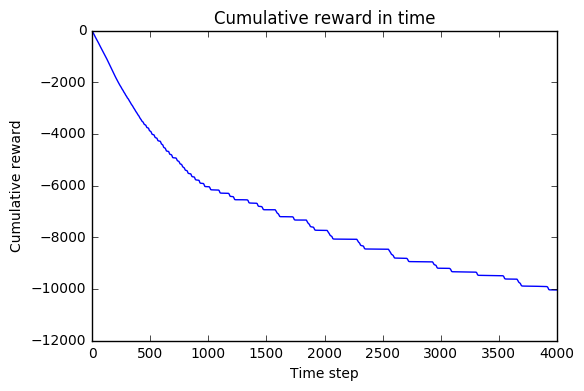

In [16]:
exp.plot_cumulative_reward()

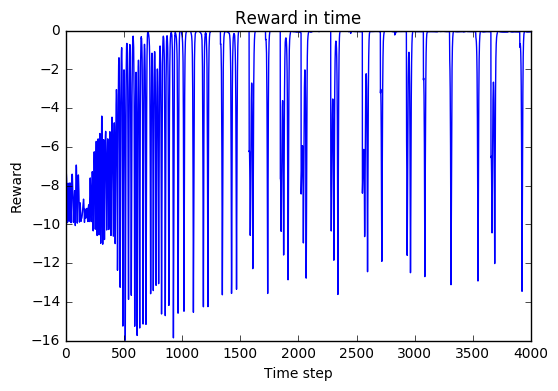

In [17]:
exp.plot_reward()

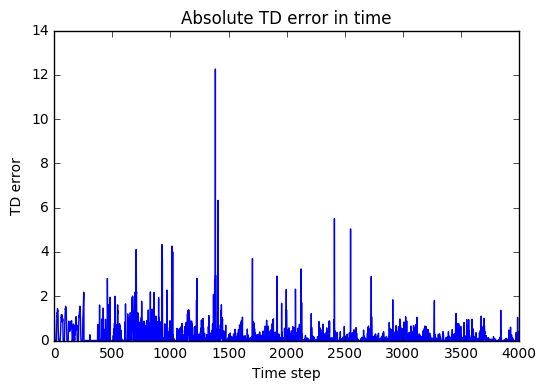

In [18]:
exp.plot_td_error()

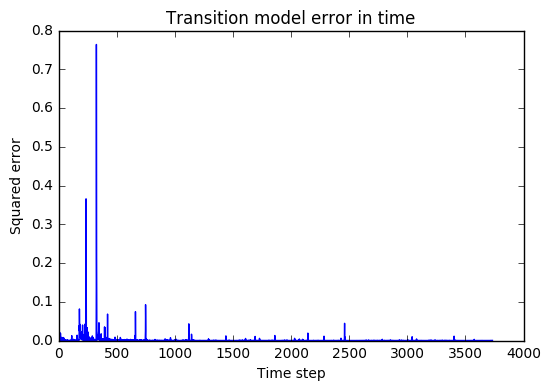

In [19]:
exp.plot_model_error(skip_steps=settings["learning_start"]+10)

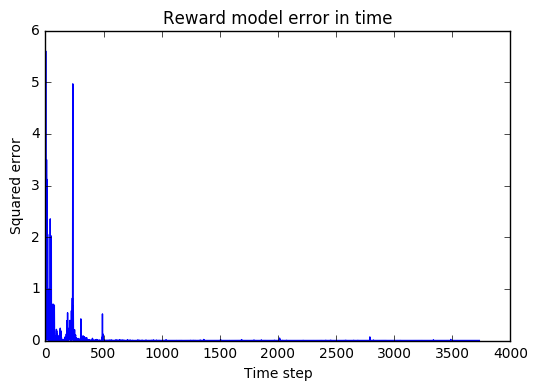

In [20]:
exp.plot_reward_error(skip_steps=settings["learning_start"]+10)

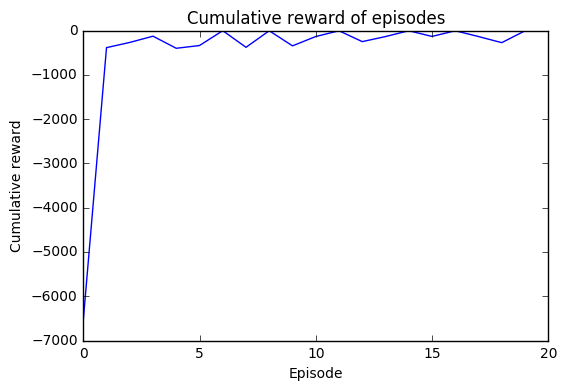

In [21]:
exp.plot_episode_reward()

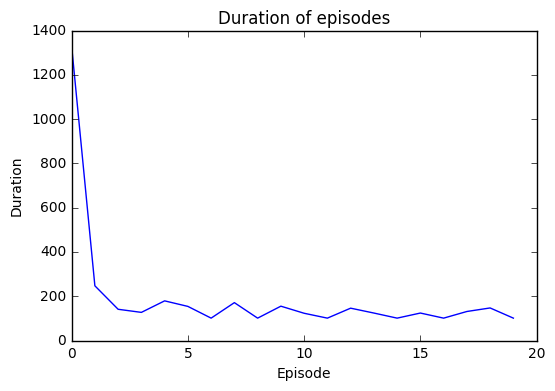

In [22]:
exp.plot_episode_duration()


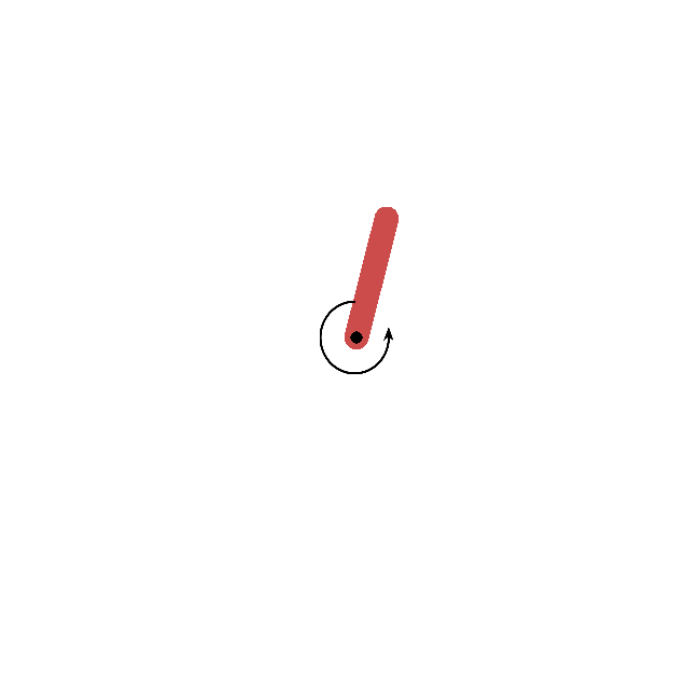
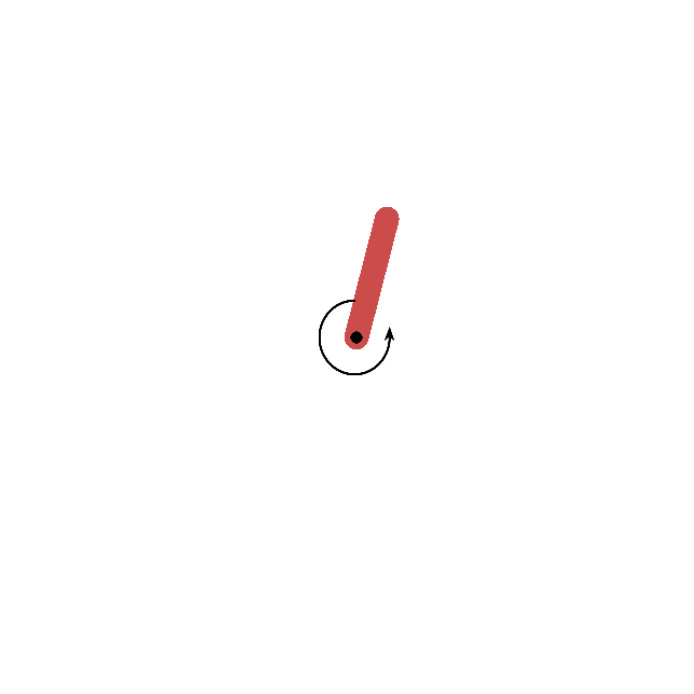
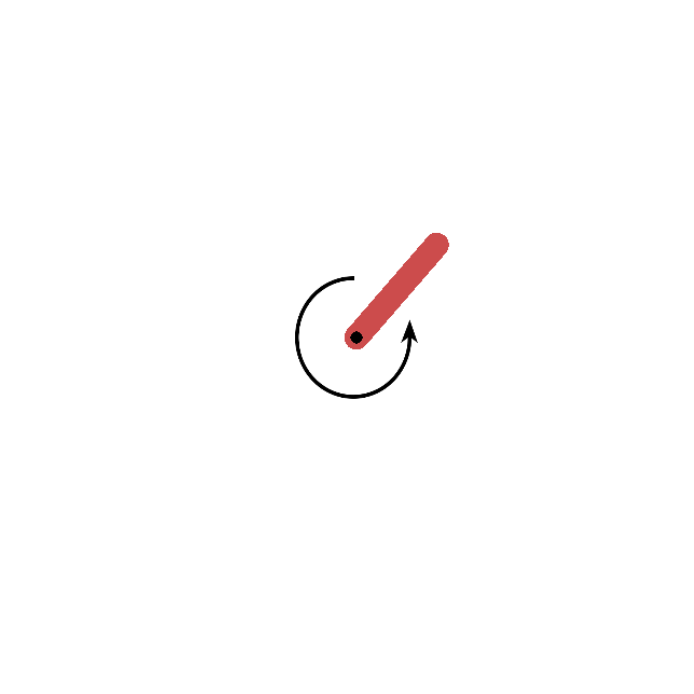
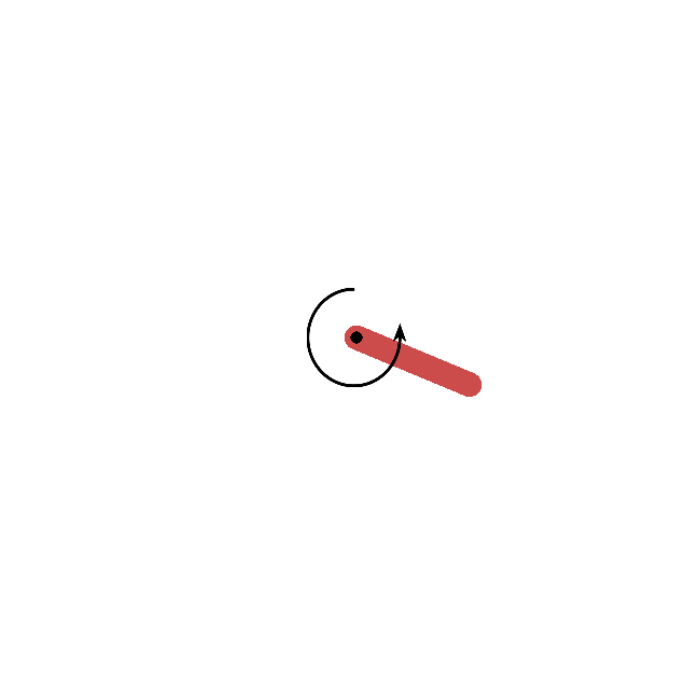
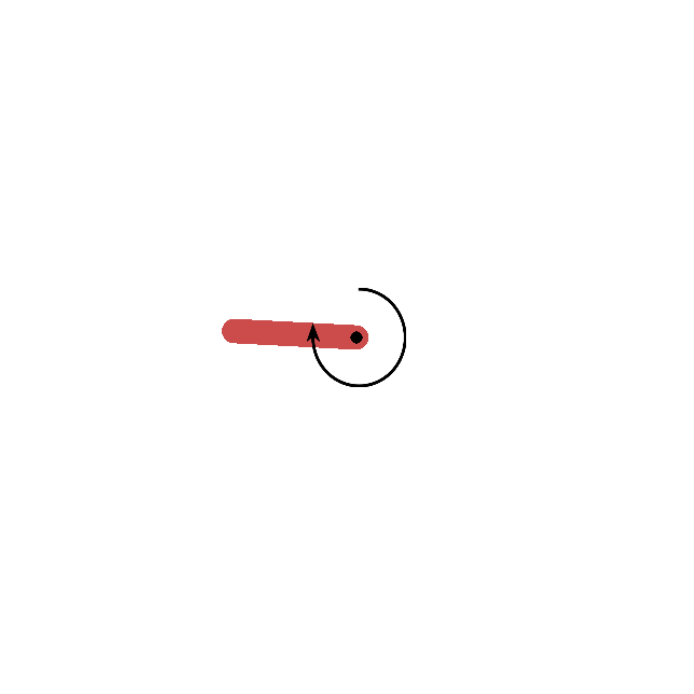
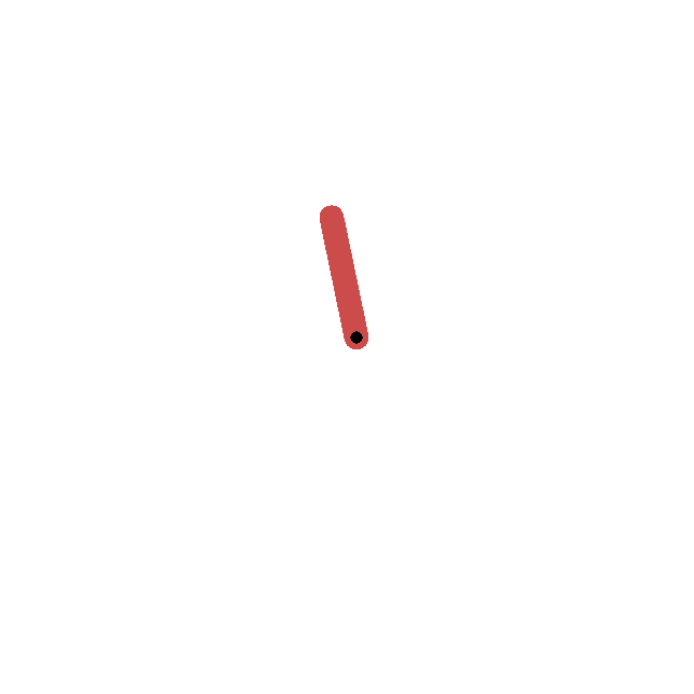
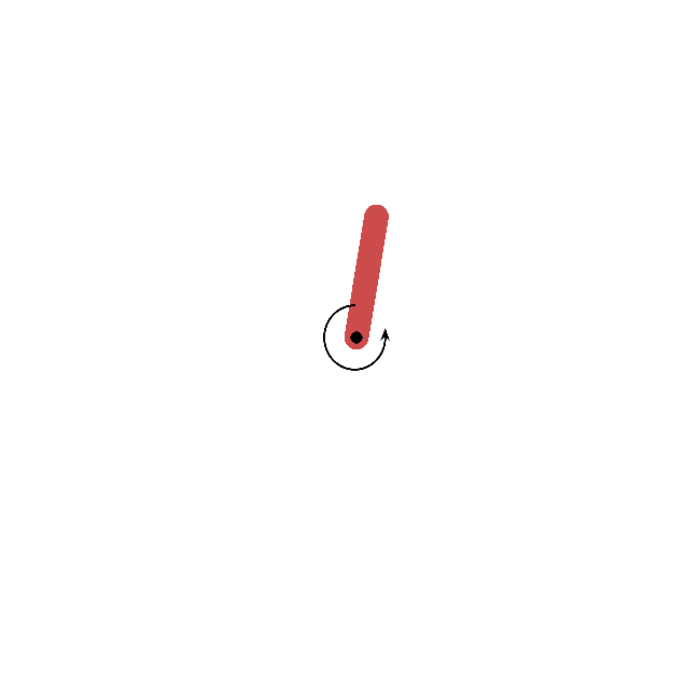
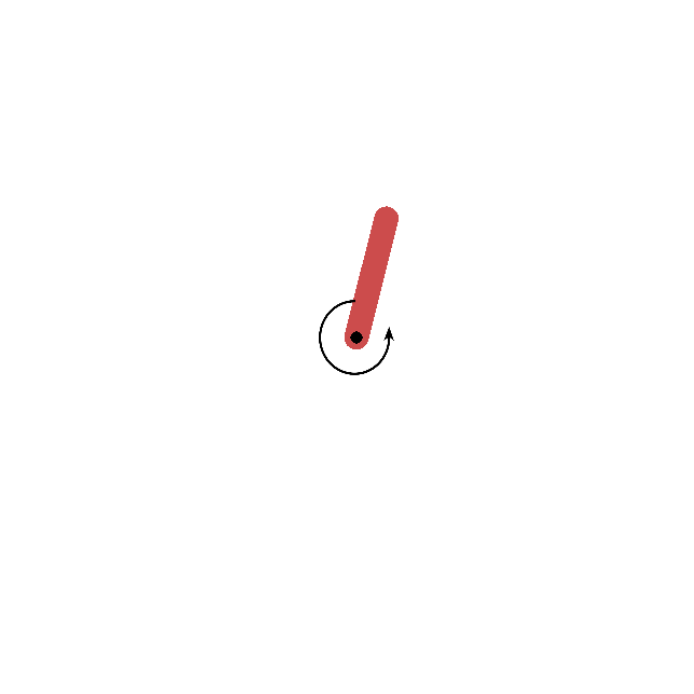
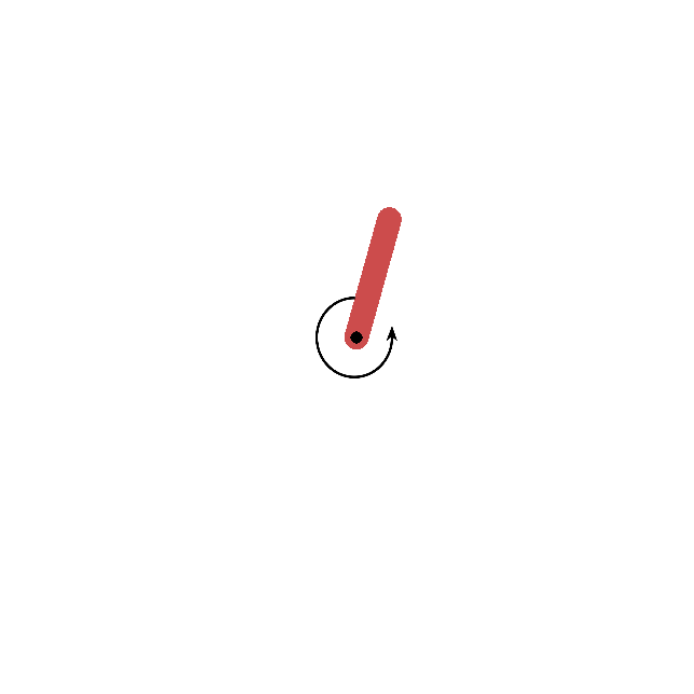
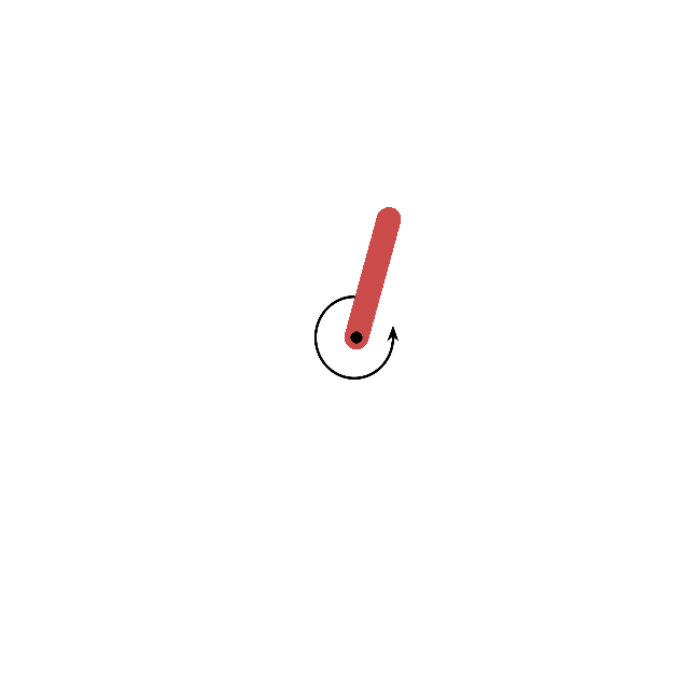
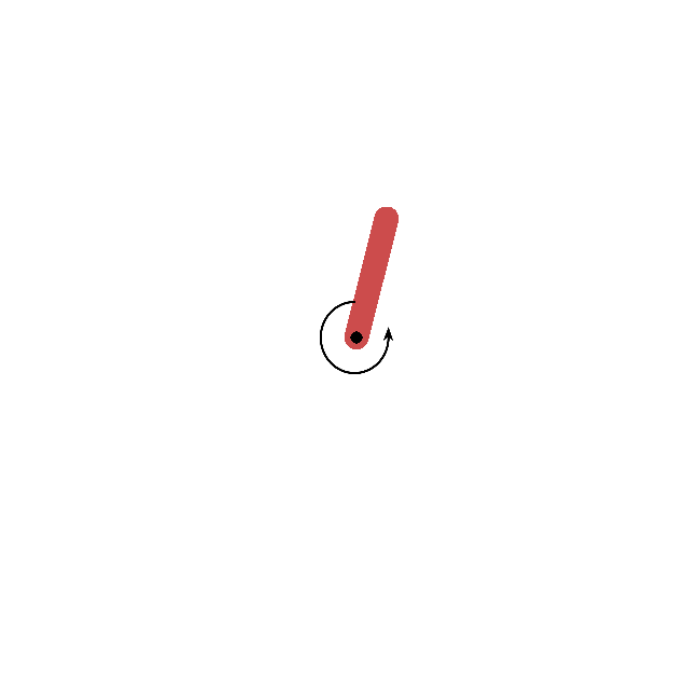
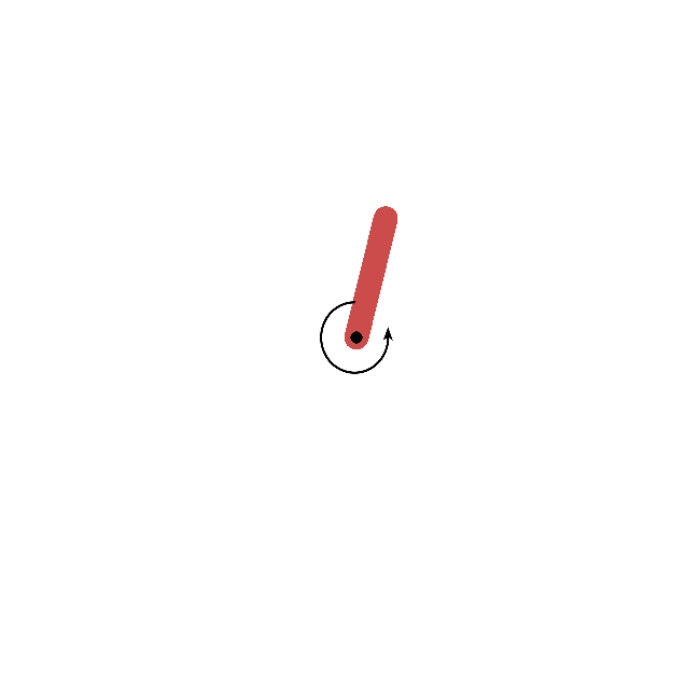
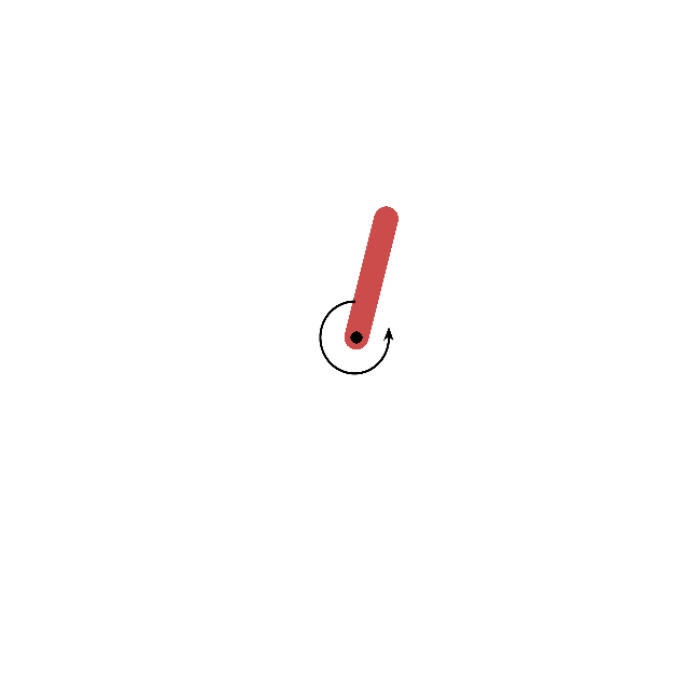
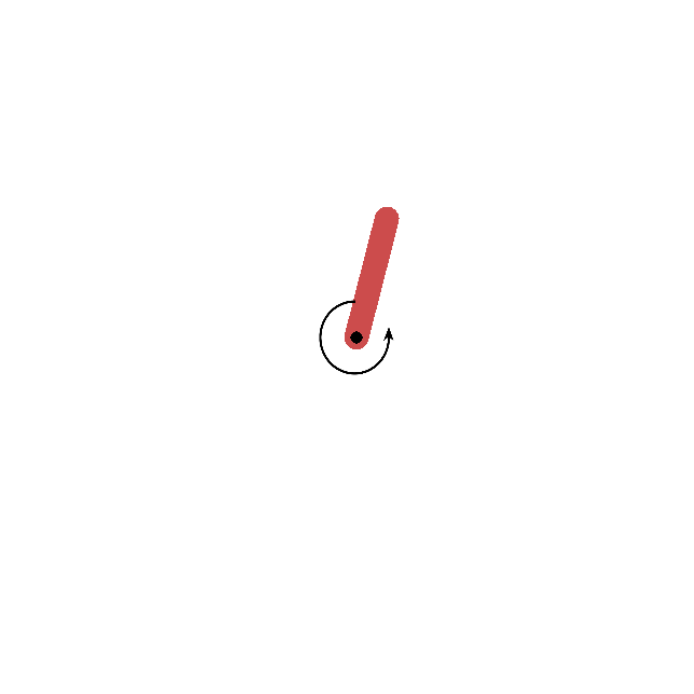
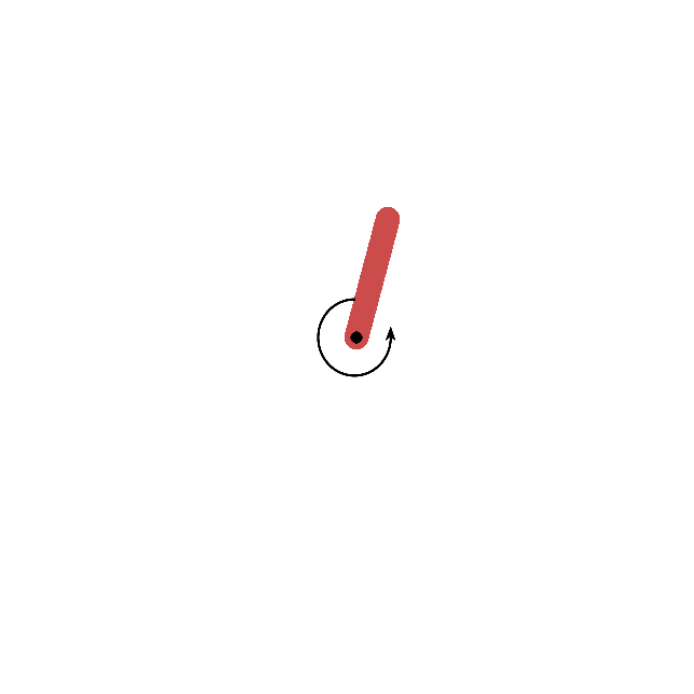
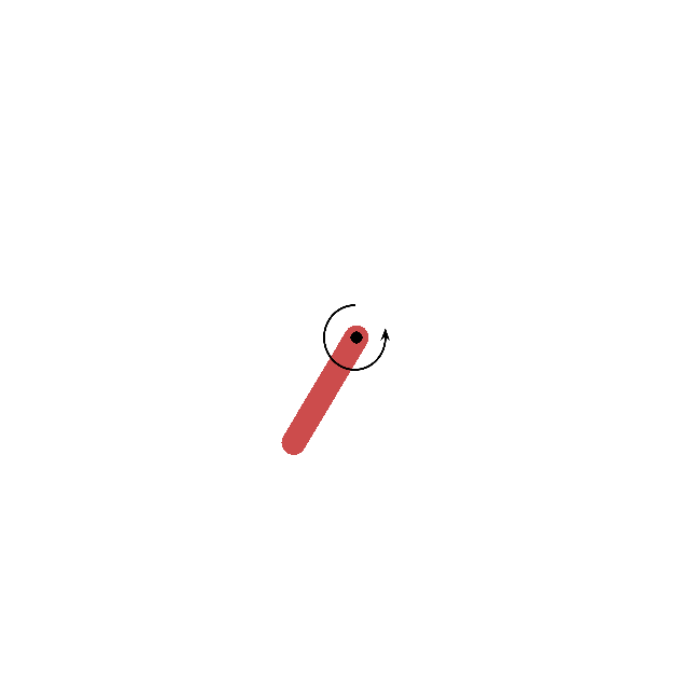
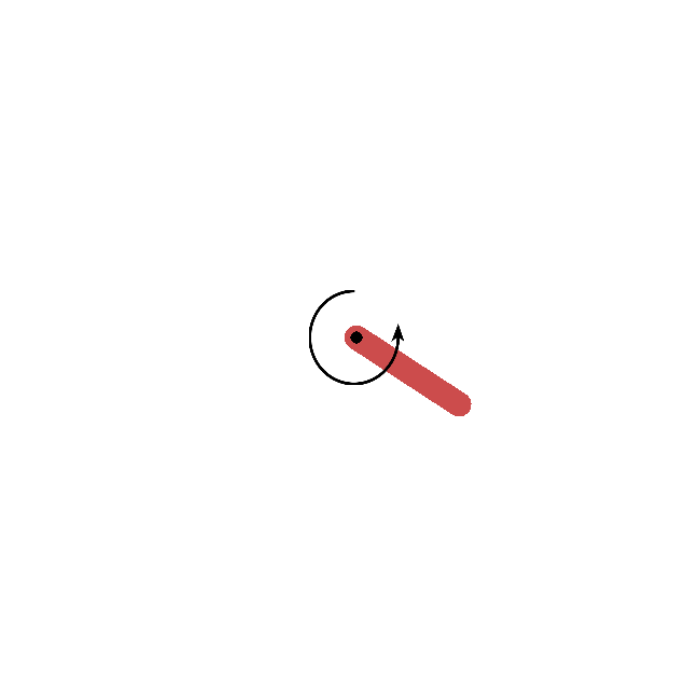
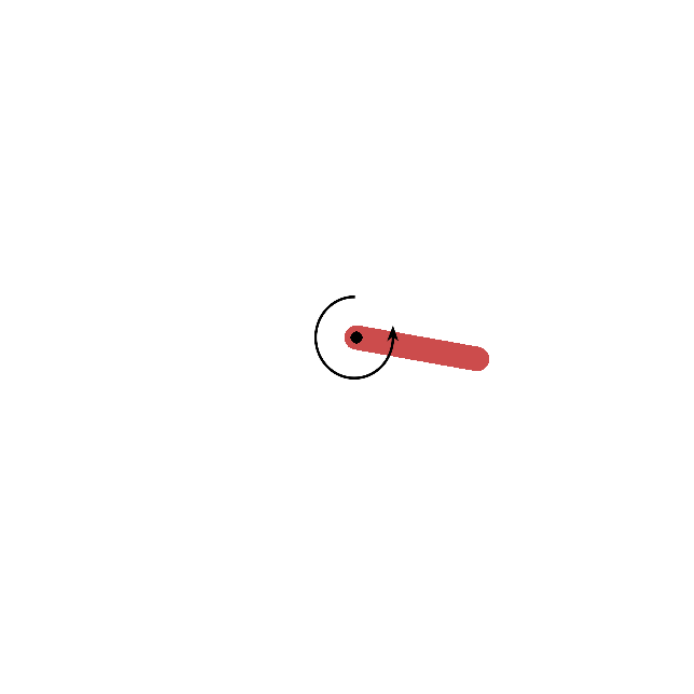
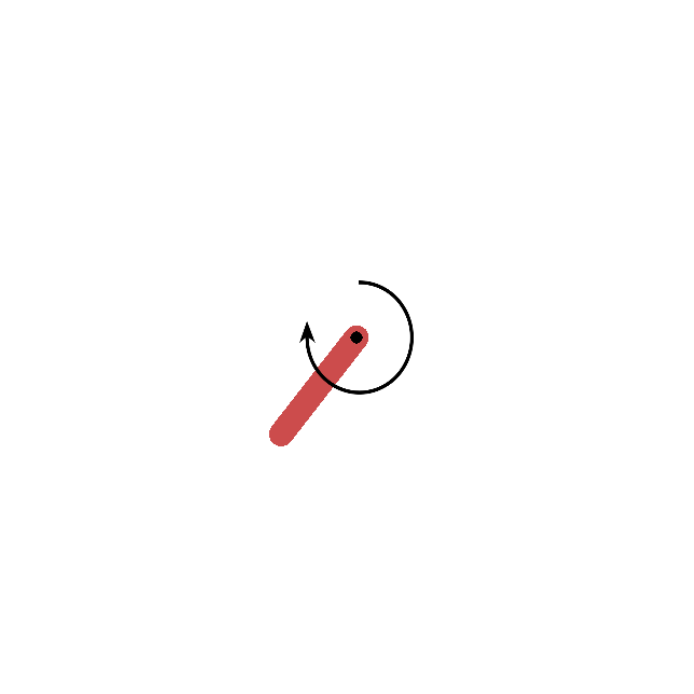
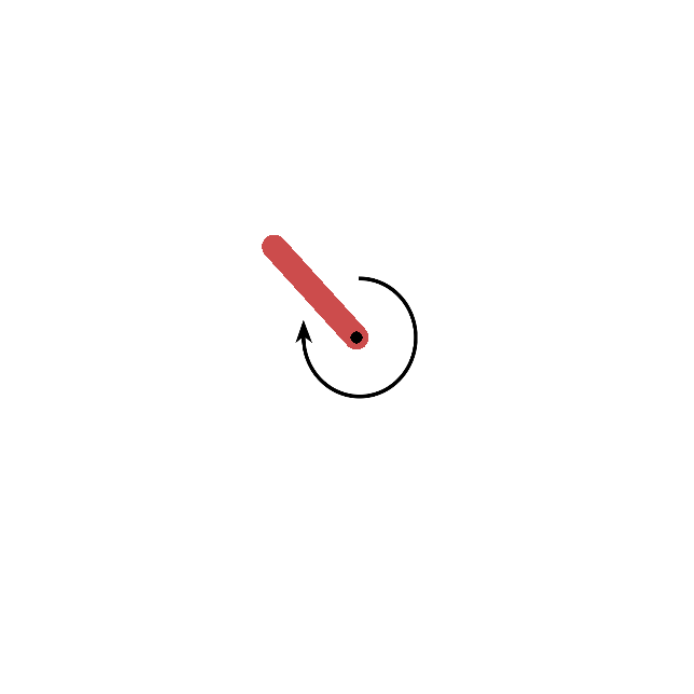
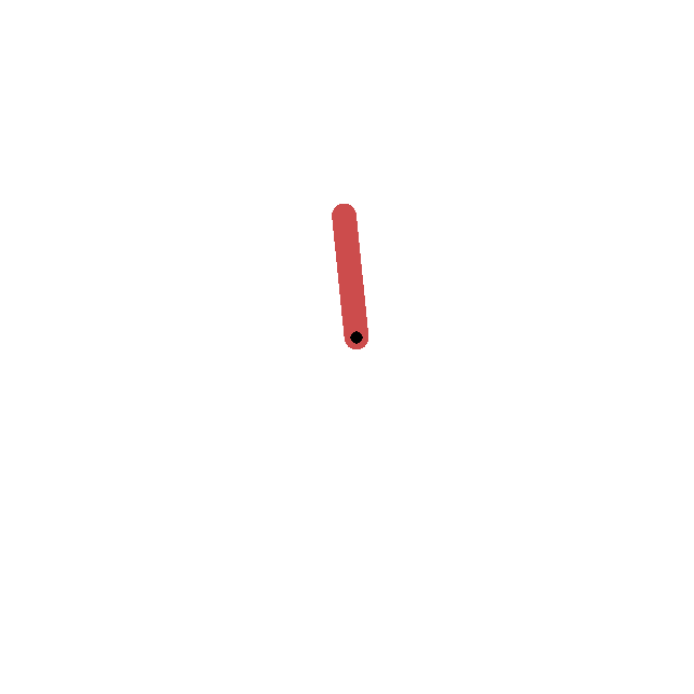
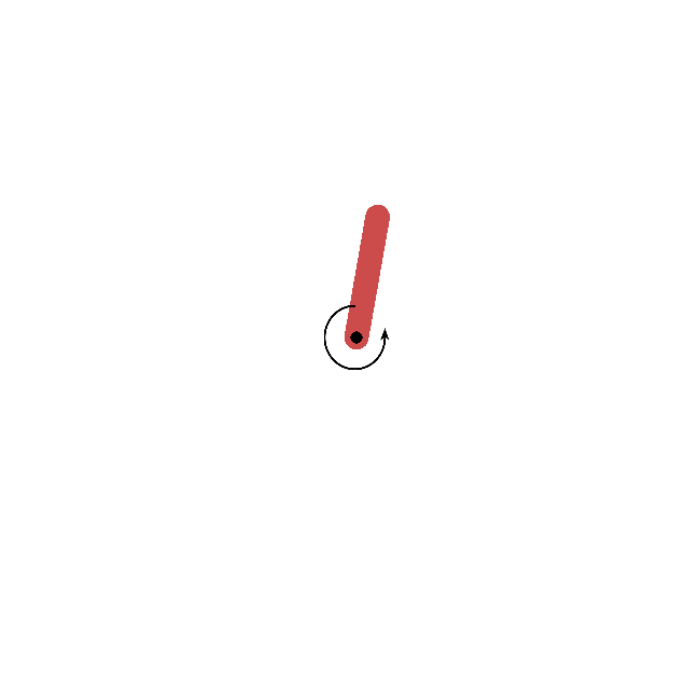
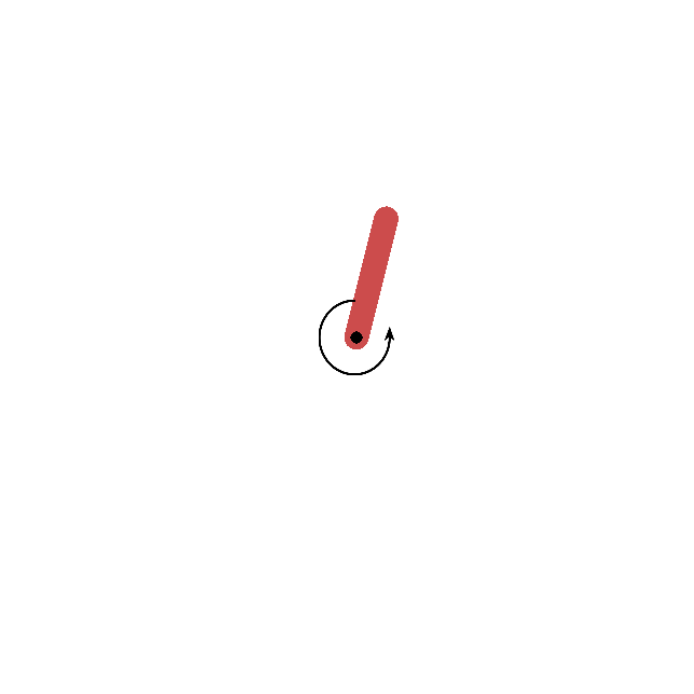
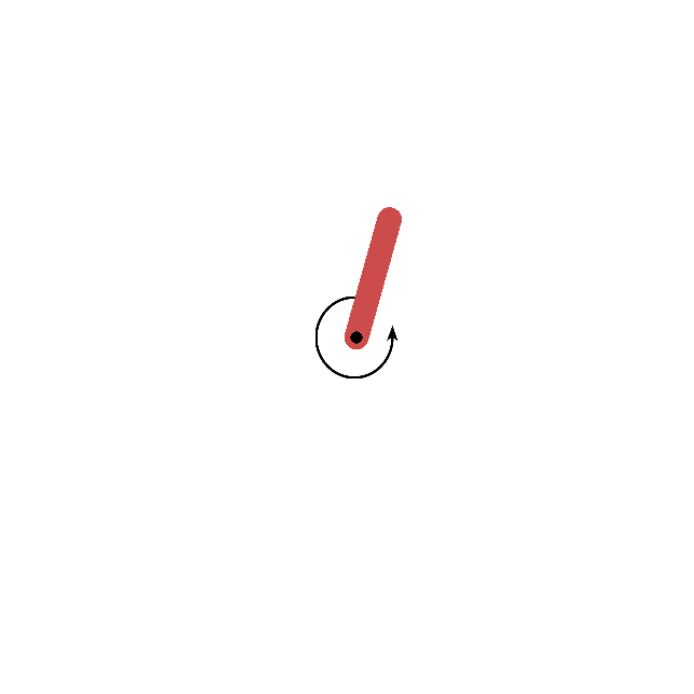
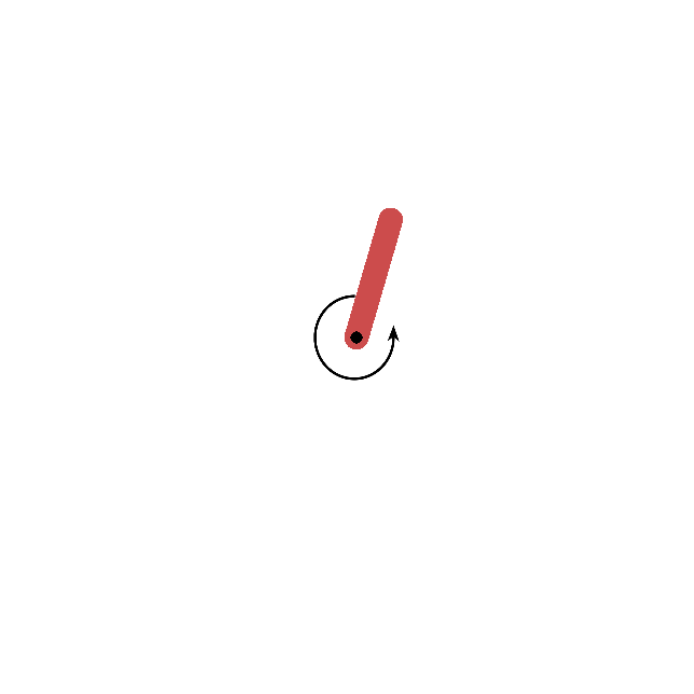
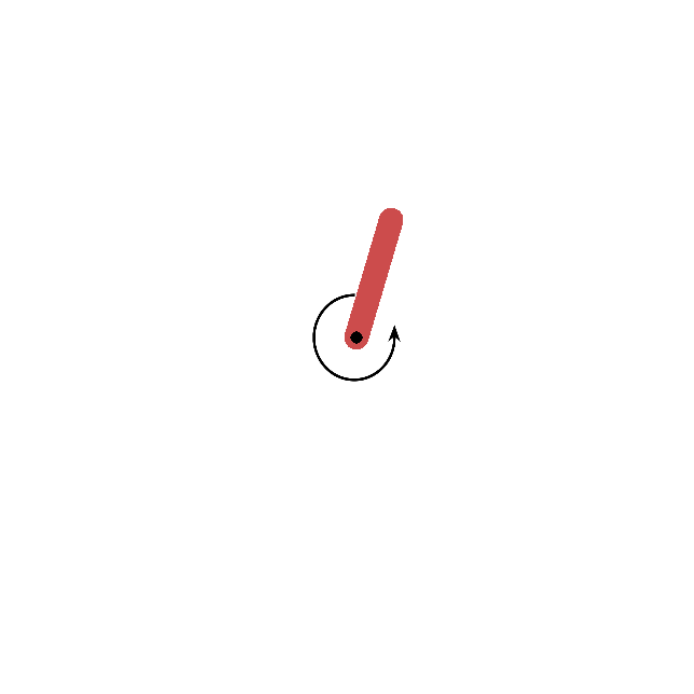
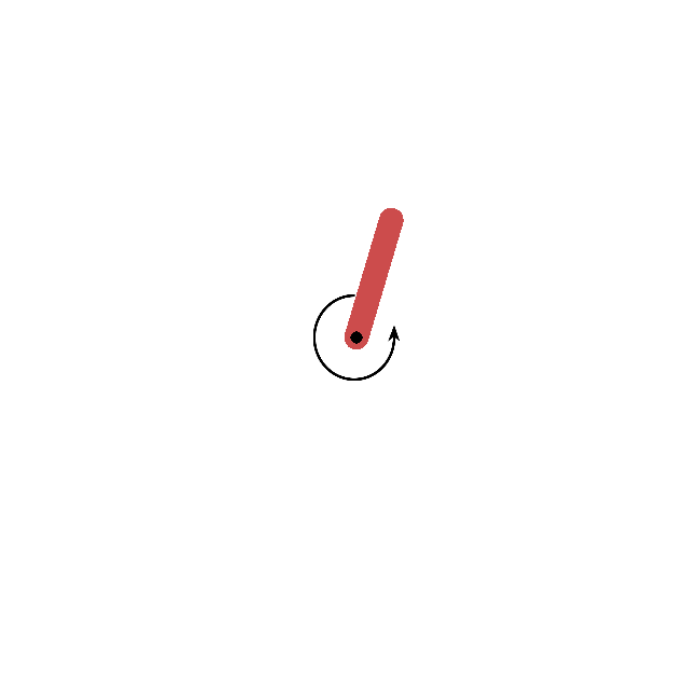
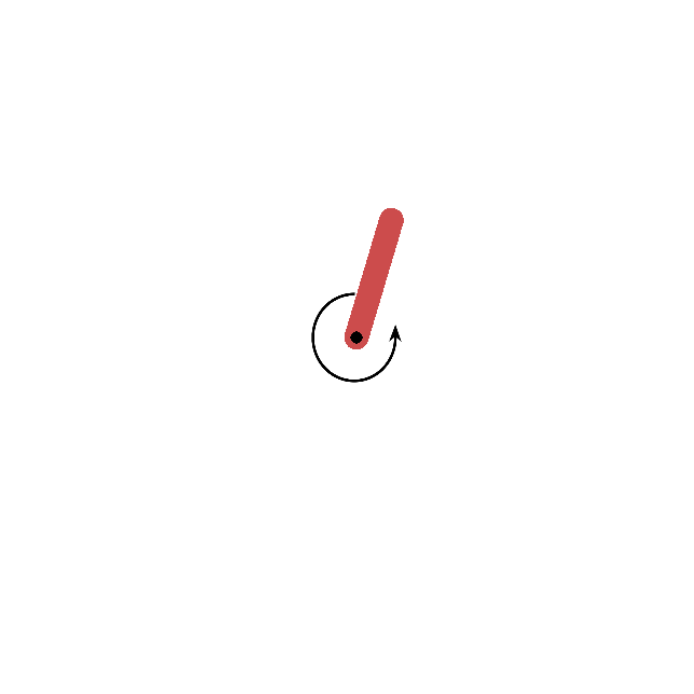
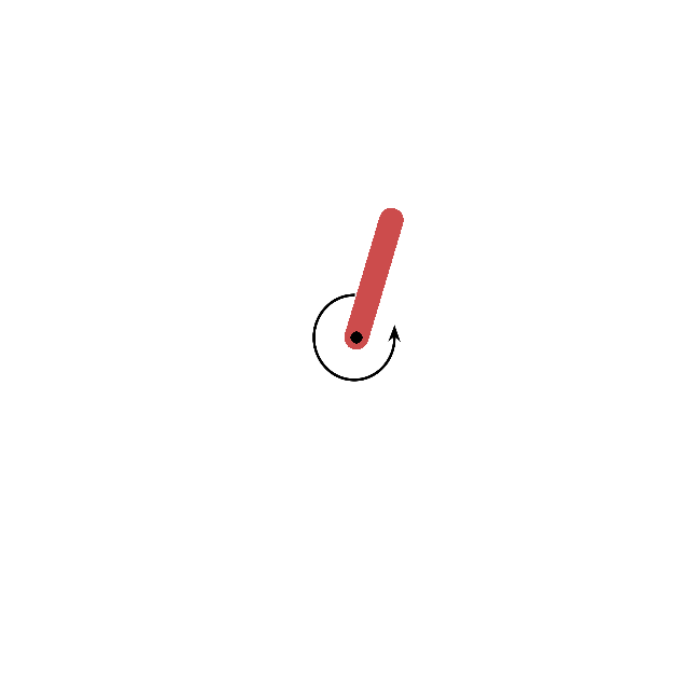
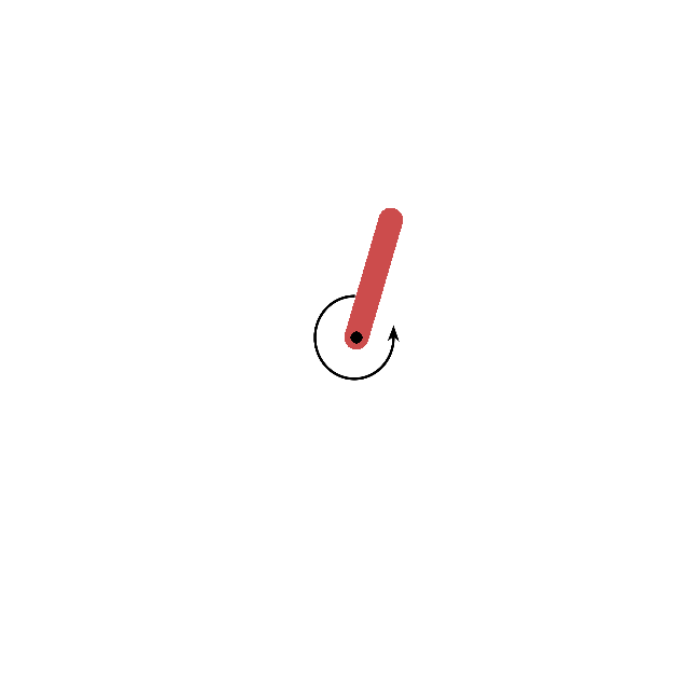
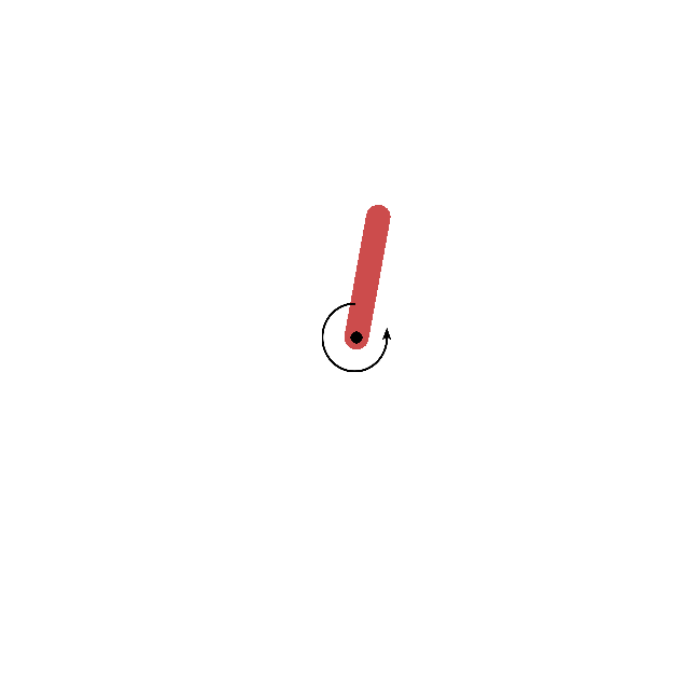
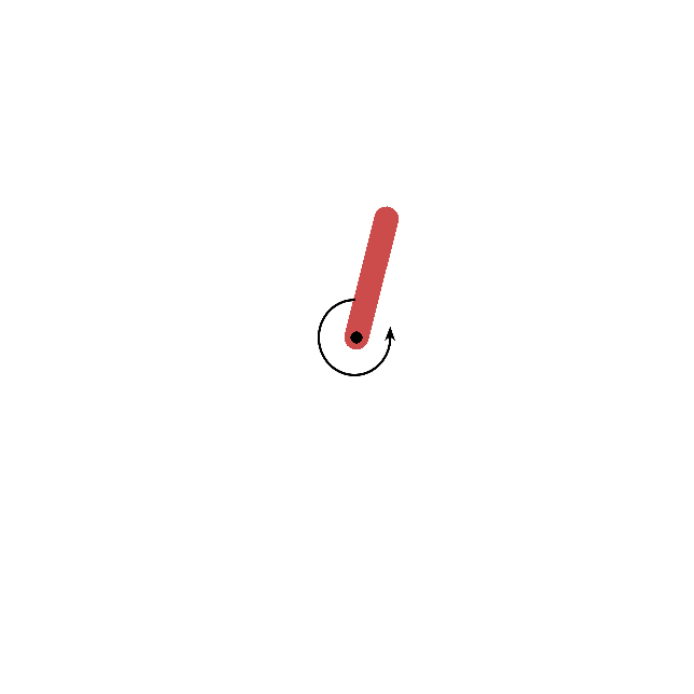
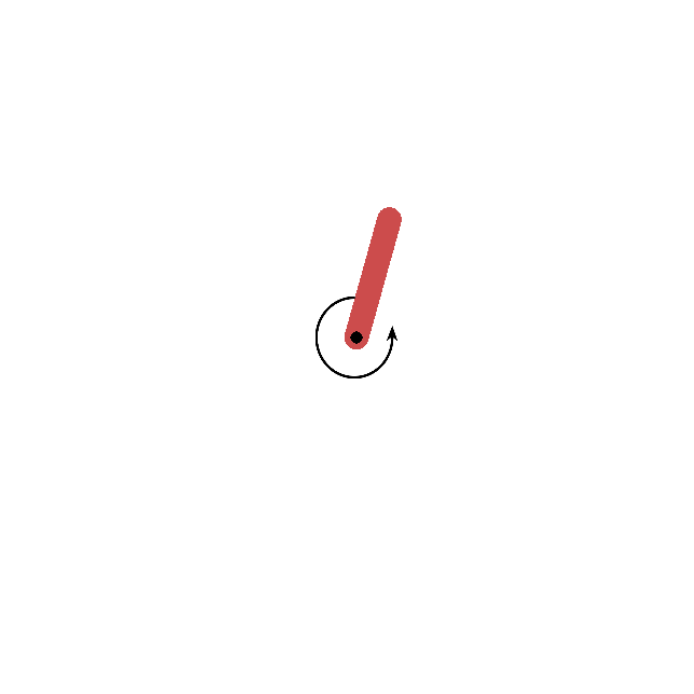
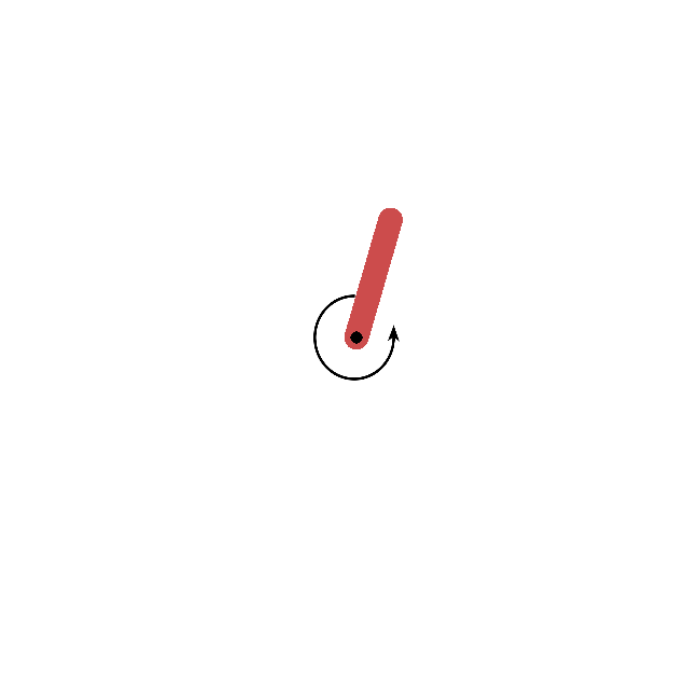
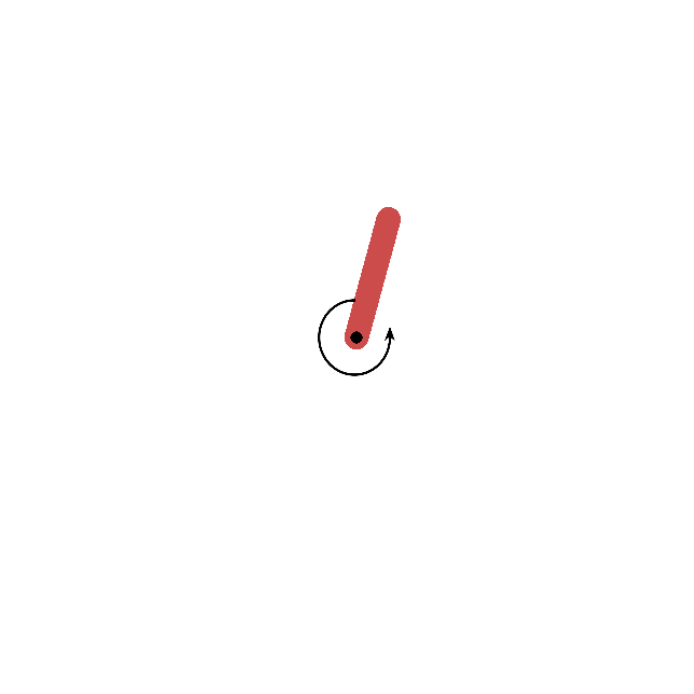
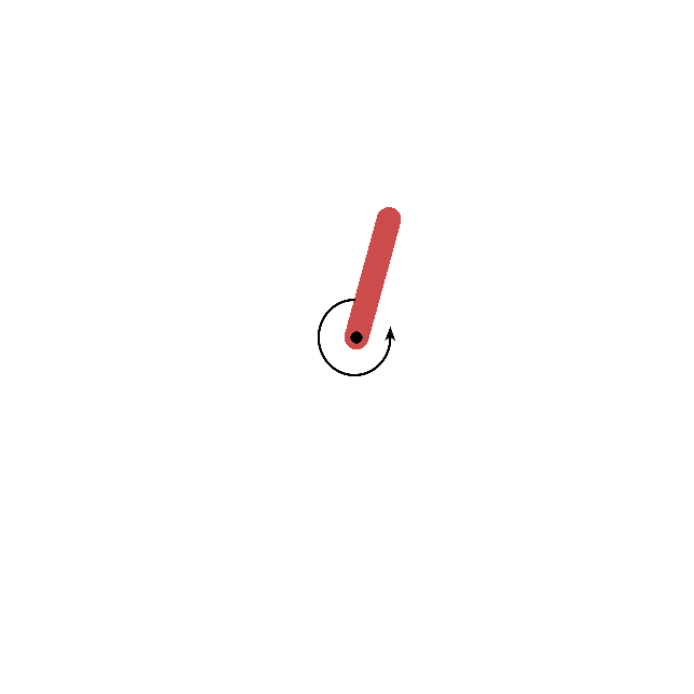
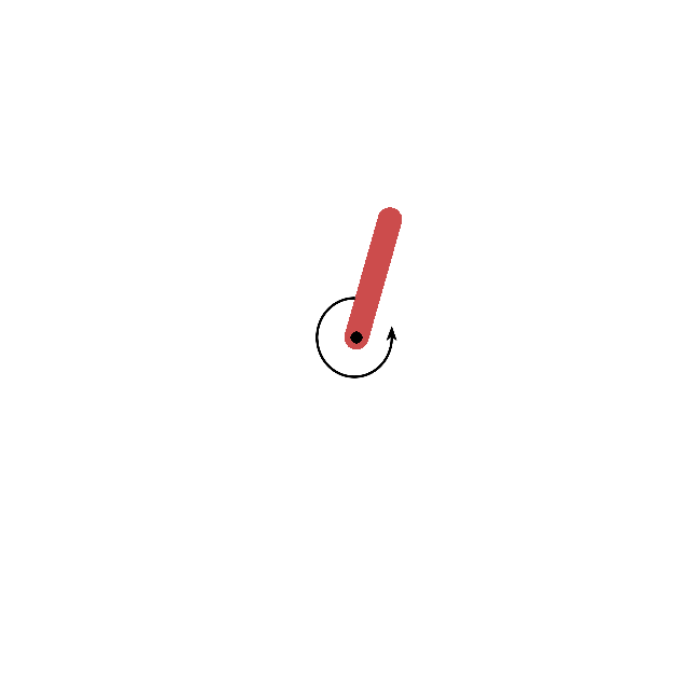
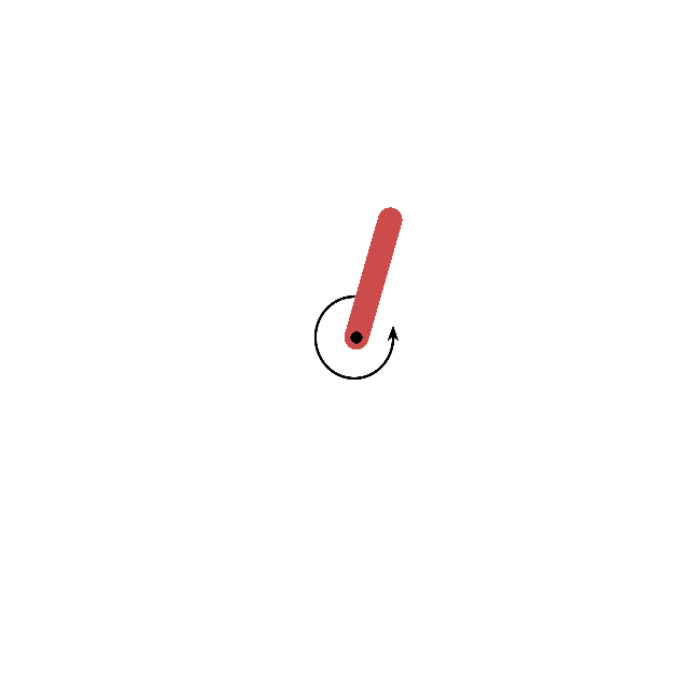
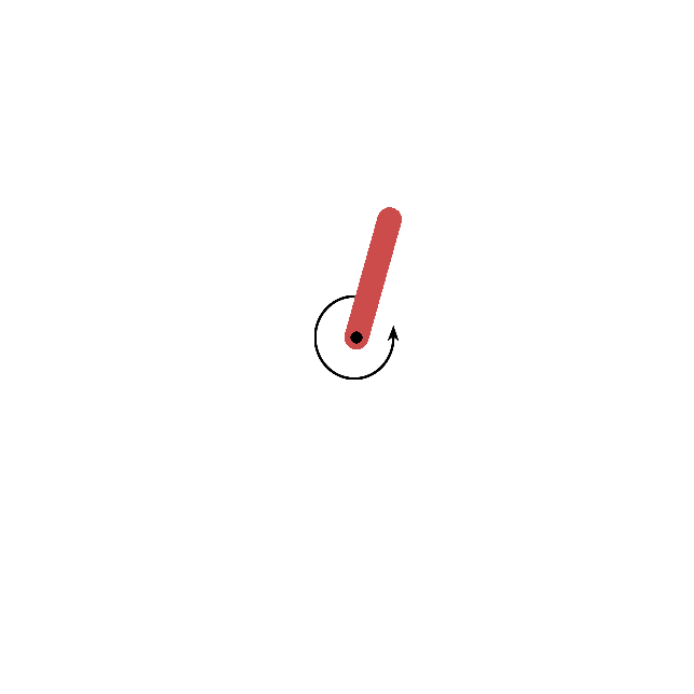
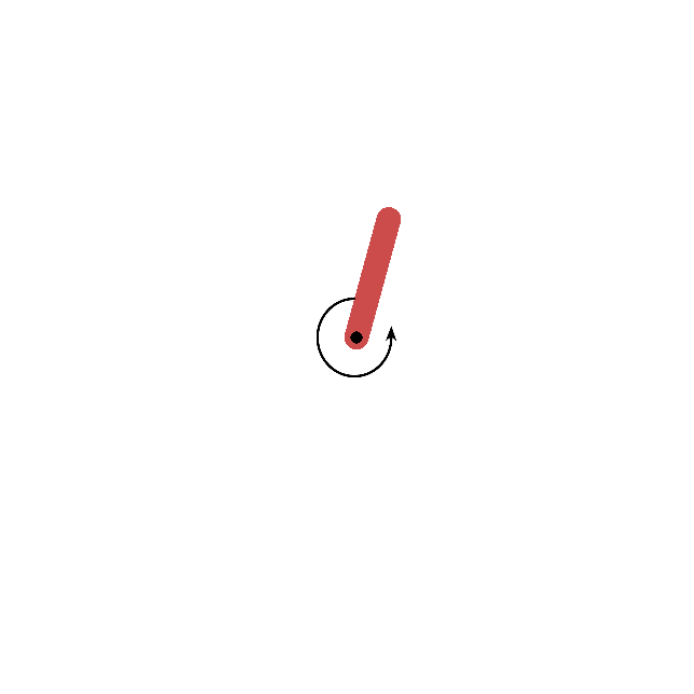
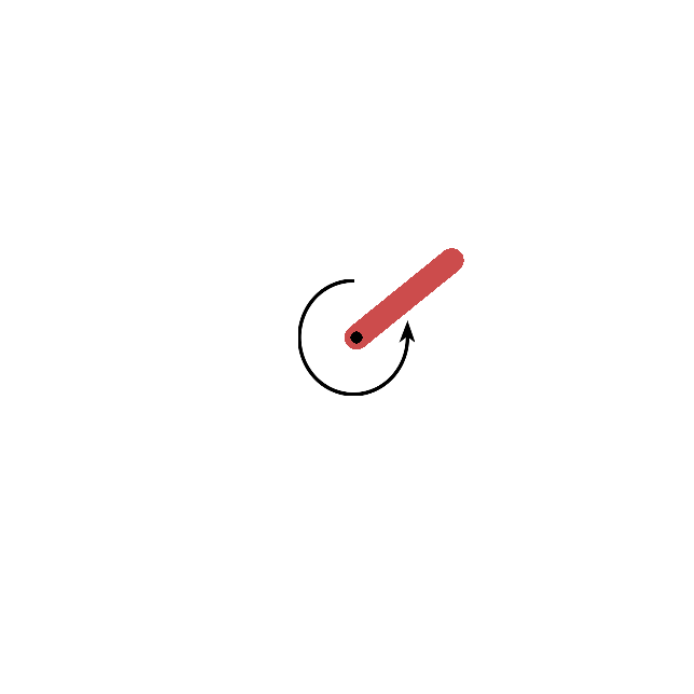
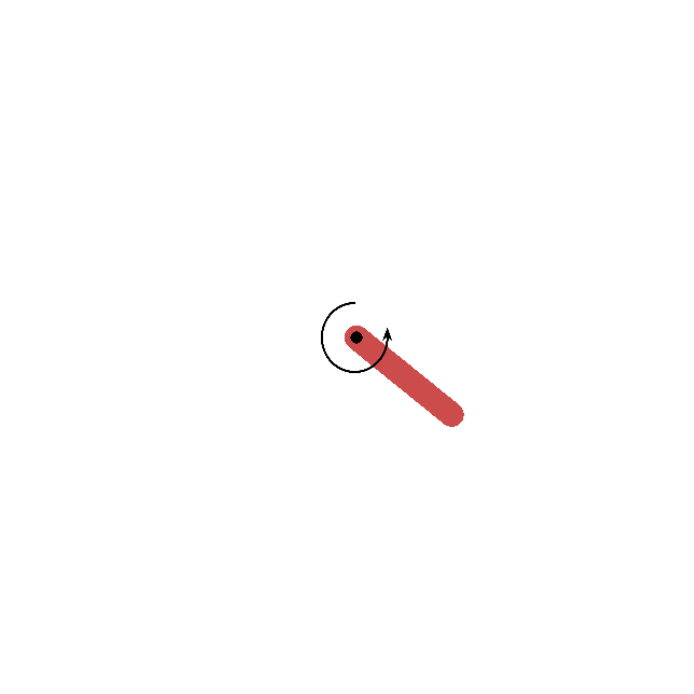
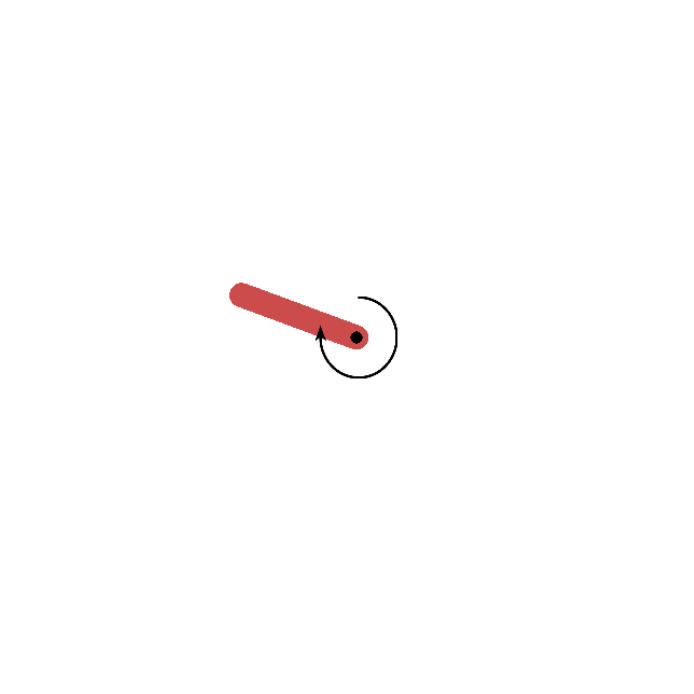
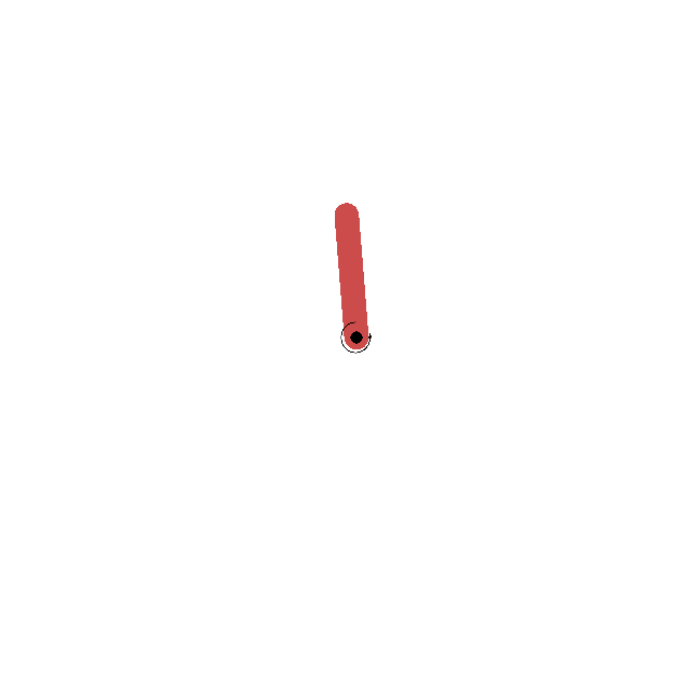
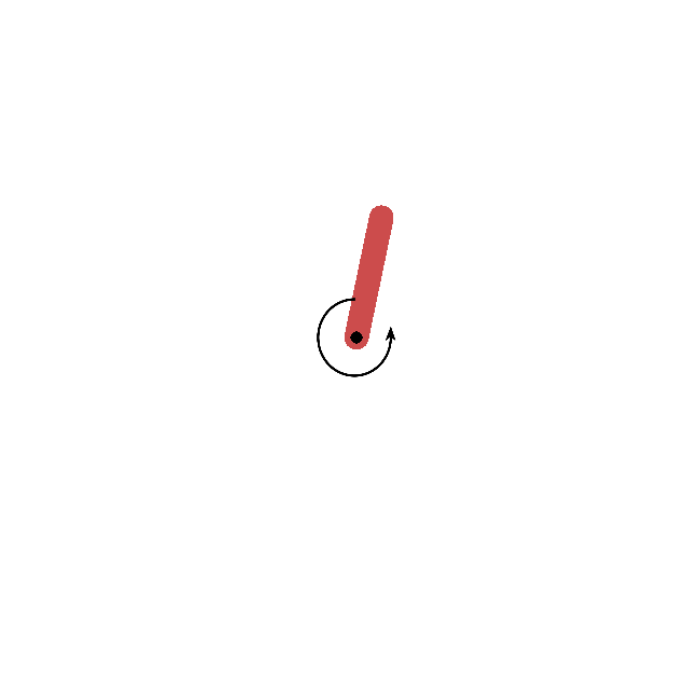
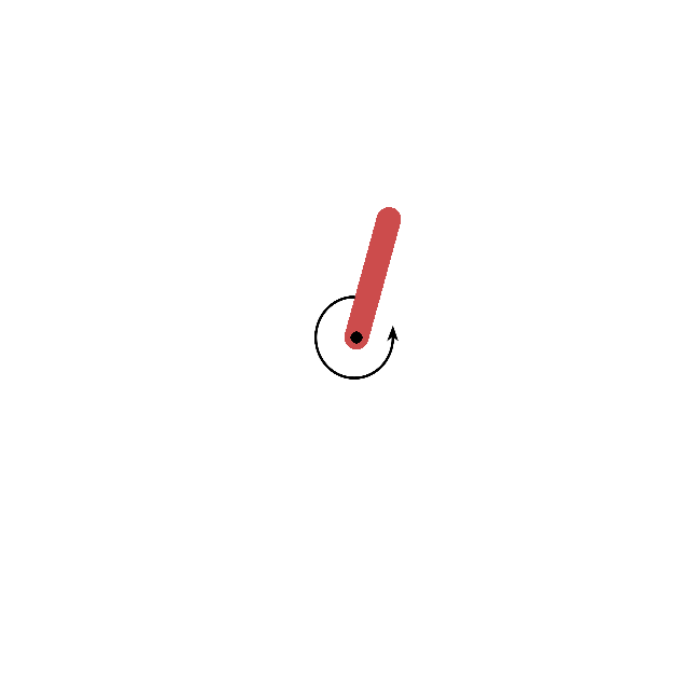
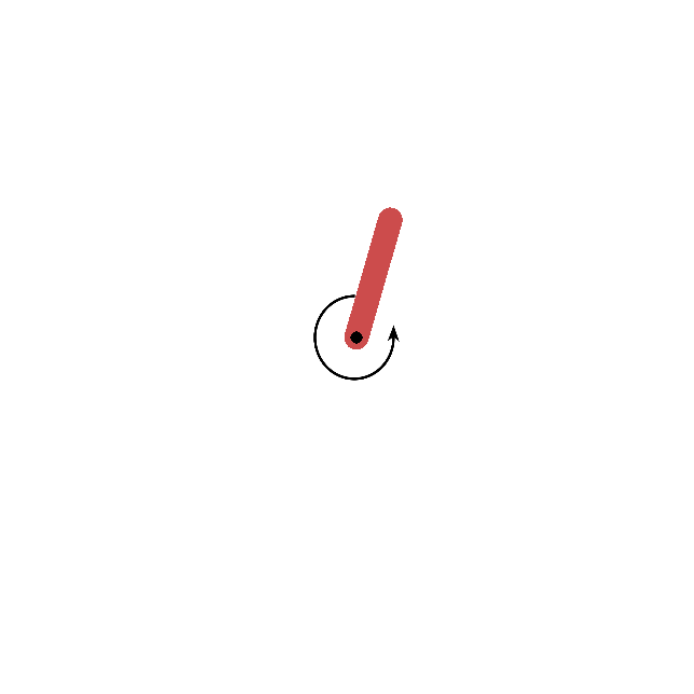
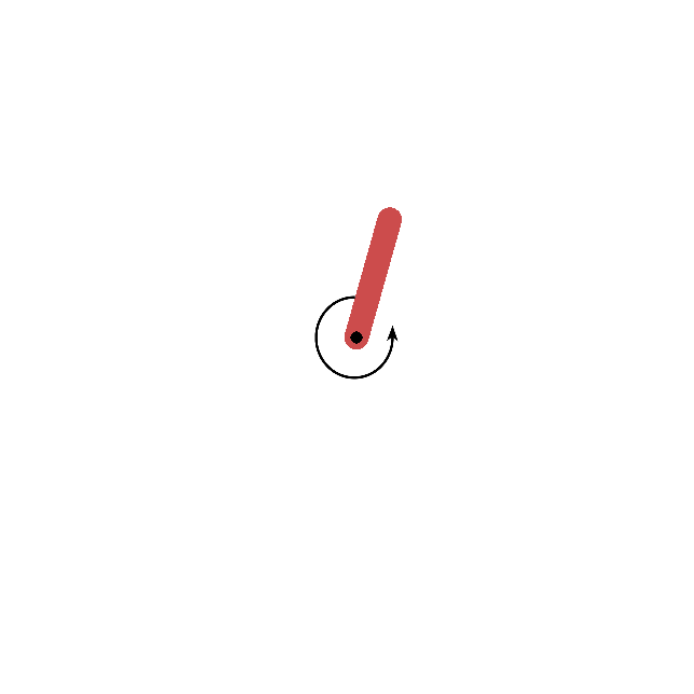
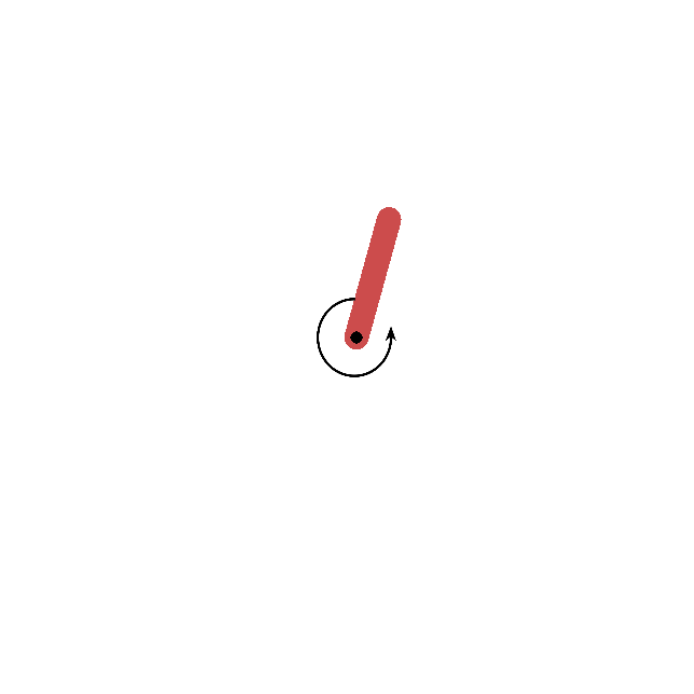

In [23]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [24]:
#session.close() 

In [25]:
exp.print_all_tf_variables()

(u'Actor_hidden_0_256_W:0', array([[-0.18203509,  0.59751642,  0.70098102, -0.96589005,  0.26659662,
        -0.91852826,  0.1755898 ,  0.6613555 , -0.69351792, -0.14711145,
         0.47271496,  0.17279263, -0.25656328,  0.20488173, -0.63514346,
         0.16082914,  0.38634586,  0.62906748,  0.11673465,  0.32827041,
         0.36532035,  0.58615422, -0.33665305, -0.04519369, -0.20806159,
         0.12297723,  1.10475707,  0.76576704, -0.8041296 , -1.40435731,
         0.27650911, -0.10724293,  0.48661014, -0.96386957,  0.31046638,
        -0.37298244,  0.36080605,  0.30481866, -0.96180642,  0.13884589,
         0.71733057,  0.66563475,  0.26368916, -0.06980616,  0.34568116,
         0.92886215, -0.35883403,  0.11436369,  0.28644633,  0.09194915,
         0.72582859, -0.08322646,  0.35795474,  0.17501992,  0.23639844,
         1.57437634, -0.9690268 , -0.31550249, -0.11917294, -0.53616887,
         0.76945126,  0.56459934,  0.08552707,  0.27537477, -0.09619884,
        -0.33742875,  0